# Classifying CIFAR-10 Images using LeNet CNN

CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers, callbacks, datasets
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Load CIFAR-10 directly from Keras' database.
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [ ]:
# Normalize pixel RGB values between 0 and 1.
X_train = X_train / 255
X_test = X_test / 255

print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)
print("Testing data shape: ", X_test.shape)
print("Testing labels shape: ", y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Testing data shape:  (10000, 32, 32, 3)
Testing labels shape:  (10000, 1)


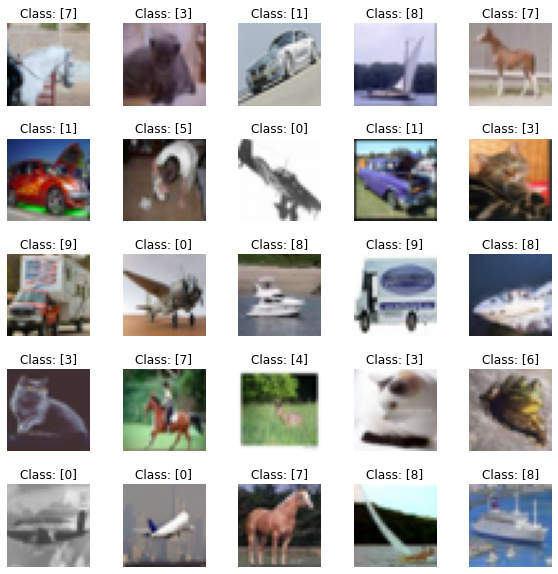

In [ ]:
# 5x5 random grid of CIFAR images to explore the data.
grid_height = 5
grid_width = 5

fig, axes = plt.subplots(grid_height, grid_width, figsize=(10, 10))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    drafted_index = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[drafted_index])
    axes[i].set_title("Class: " + str(y_train[drafted_index]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [ ]:
# Sequential model with convolutional layers and many Dropout layers to
# mitigate overfitting:
# Conv -> Conv -> MaxPool -> Dropout ->
# Conv -> Conv -> MaxPool -> Dropout ->
# Flatten -> Dense -> Dropout ->
# Dense -> Dropout -> Dense
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(32, 32, 3)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D())
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D())
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(800, activation='relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(400, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 10, 10, 64)        36928     
                                                      

In [ ]:
# Monitor accuracy because loss can increase while accuracy improves.
early_stopping_callback = callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=5,
                                                  restore_best_weights=True)
# LR reduction to help the gradient get to the minima.
learning_rate_callback = callbacks.ReduceLROnPlateau(patience=5)
batch_size = X_train.shape[0] // 200

cnn_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
                  metrics='accuracy')

# Since the dataset has only 10 classes, 100 epochs are enough for this
# model.
epochs_info = cnn_model.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=100,
                            callbacks=[early_stopping_callback,
                                       learning_rate_callback],
                            validation_split=0.15)

Epoch 1/100
170/170 [==============================] - 157s 791ms/step - loss: 1.9619 - accuracy: 0.2929 - val_loss: 1.6990 - val_accuracy: 0.4075 - lr: 0.0010
Epoch 2/100
170/170 [==============================] - 136s 799ms/step - loss: 1.5584 - accuracy: 0.4412 - val_loss: 1.3261 - val_accuracy: 0.5297 - lr: 0.0010
Epoch 3/100
170/170 [==============================] - 135s 792ms/step - loss: 1.3350 - accuracy: 0.5265 - val_loss: 1.5131 - val_accuracy: 0.4717 - lr: 0.0010
Epoch 4/100
170/170 [==============================] - 135s 795ms/step - loss: 1.1866 - accuracy: 0.5811 - val_loss: 1.0643 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 5/100
170/170 [==============================] - 135s 793ms/step - loss: 1.0575 - accuracy: 0.6297 - val_loss: 0.9924 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/100
170/170 [==============================] - 135s 793ms/step - loss: 0.9416 - accuracy: 0.6695 - val_loss: 0.8721 - val_accuracy: 0.6969 - lr: 0.0010
Epoch 7/100
170/170 [===================

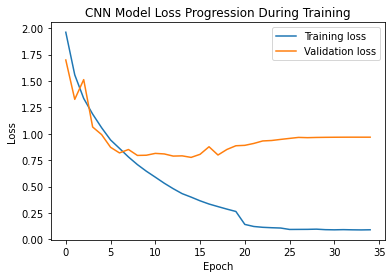

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("CNN Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

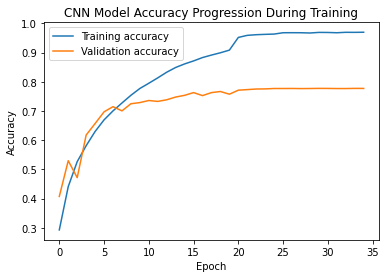

In [ ]:
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.title("CNN Model Accuracy Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

In [ ]:
cnn_model.evaluate(X_test, y_test)

313/313 [==============================] - 9s 29ms/step - loss: 0.9833 - accuracy: 0.7775


[0.983313262462616, 0.7774999737739563]

In [ ]:
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

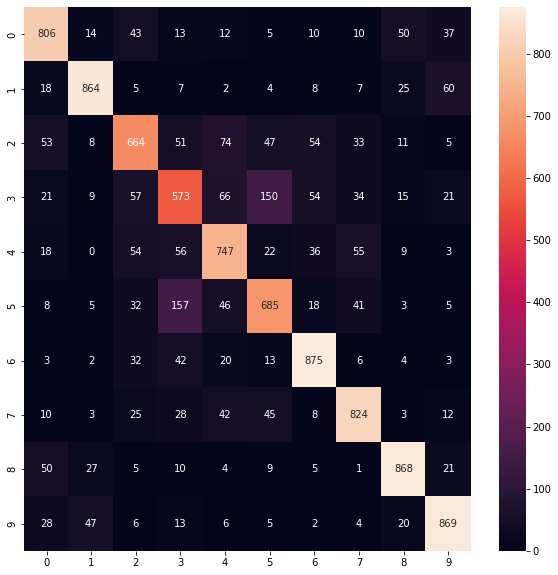

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
target_names = [
    "Class 0: Airplane",
    "Class 1: Automobile",
    "Class 2: Bird",
    "Class 3: Cat",
    "Class 4: Deer",
    "Class 5: Dog",
    "Class 6: Frog",
    "Class 7: Horse",
    "Class 8: Ship",
    "Class 9: Truck"
]

print(classification_report(y_test, y_pred_classes, target_names=target_names))

                     precision    recall  f1-score   support

  Class 0: Airplane       0.79      0.81      0.80      1000
Class 1: Automobile       0.88      0.86      0.87      1000
      Class 2: Bird       0.72      0.66      0.69      1000
       Class 3: Cat       0.60      0.57      0.59      1000
      Class 4: Deer       0.73      0.75      0.74      1000
       Class 5: Dog       0.70      0.69      0.69      1000
      Class 6: Frog       0.82      0.88      0.85      1000
     Class 7: Horse       0.81      0.82      0.82      1000
      Class 8: Ship       0.86      0.87      0.86      1000
     Class 9: Truck       0.84      0.87      0.85      1000

           accuracy                           0.78     10000
          macro avg       0.78      0.78      0.78     10000
       weighted avg       0.78      0.78      0.78     10000



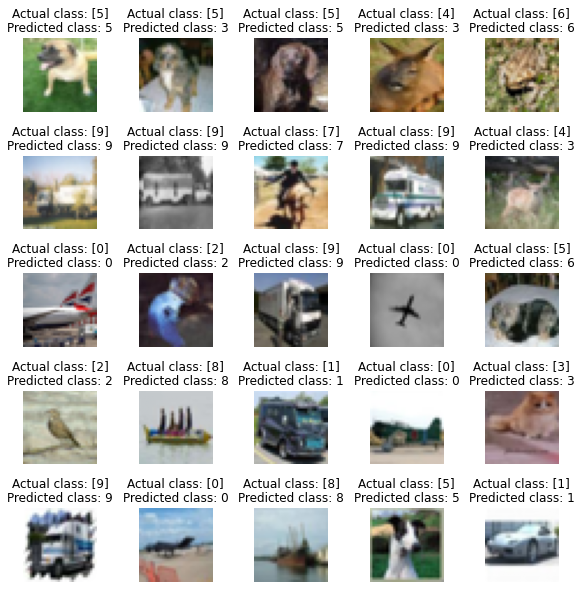

In [ ]:
# 5x5 random grid of CIFAR images along with their predicted classes for
# each drafted image.
grid_height = 5
grid_width = 5

fig, axes = plt.subplots(grid_height, grid_width, figsize=(10, 10))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    drafted_index = np.random.randint(0, X_test.shape[0])
    axes[i].imshow(X_test[drafted_index])
    axes[i].set_title(
        "Actual class: {}\nPredicted class: {}"
        .format(y_test[drafted_index], y_pred_classes[drafted_index])
    )
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.6)